In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lizapuspitap","key":"9ee8219d54e4d1e6ccd2e44d3e7937bf"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d jarredpriester/global-population

  0% 0.00/474 [00:00<?, ?B/s]
100% 474/474 [00:00<00:00, 1.02MB/s]


In [4]:
!mkdir global-population
!unzip global-population.zip -d global-population
!ls global-population

Archive:  global-population.zip
  inflating: global-population/Global_annual_population.csv  
Global_annual_population.csv


In [5]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [16]:
df = pd.read_csv('/content/global-population/Global_annual_population.csv')

In [17]:
df.head()

,Year,Population,Unnamed: 2
0,1960,3.03,NaN
1,1961,3.07,NaN
2,1962,3.12,NaN
3,1963,3.19,NaN
4,1964,3.26,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         62 non-null     int64  
 1    Population  62 non-null     float64
 2   Unnamed: 2   0 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 1.6 KB


In [19]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [20]:
df.drop(['Unnamed: 2'], axis=1, inplace=True)

In [22]:
df.set_index(['Year'], inplace=True)

In [23]:
df.head()

,Population
Year,
1960-01-01,3.03
1961-01-01,3.07
1962-01-01,3.12
1963-01-01,3.19
1964-01-01,3.26


In [24]:
df.index.min(), df.index.max()

(Timestamp('1960-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00'))

In [25]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')

In [26]:
df.index.freq = 'YS'

<Axes: xlabel='Year'>

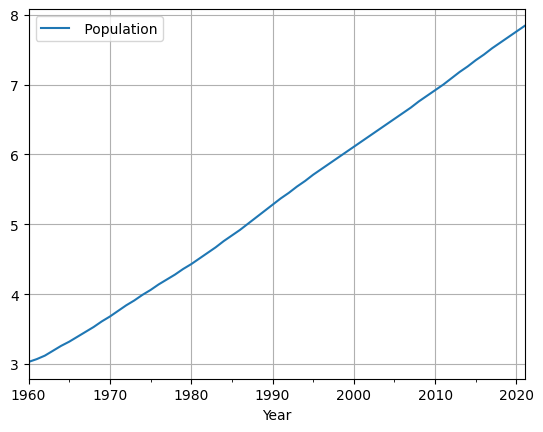

In [27]:
df.plot(grid=True)

In [46]:
df.rename(columns={' Population': 'Population'}, inplace=True)

In [47]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

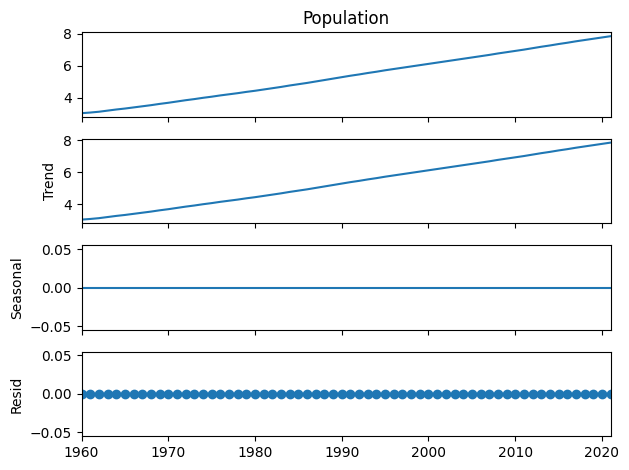

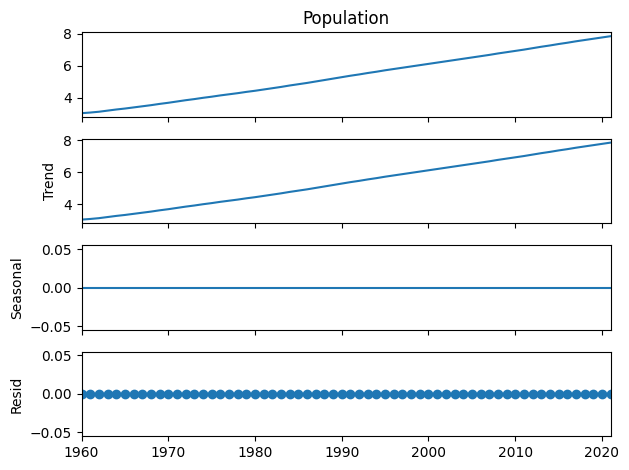

In [48]:
decompose_add = seasonal_decompose(df['Population'])
decompose_add.plot()

In [49]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('----------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic','p-value','Lags Used','Number of Observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 0.556886
p-value                        0.986503
Lags Used                      3.000000
Number of Observation Used    58.000000
Critical Value (1%)           -3.548494
Critical Value (5%)           -2.912837
Critical Value (10%)          -2.594129
dtype: float64


In [50]:
diff_df = df.diff()
diff_df.head()

,Population
Year,
1960-01-01,NaN
1961-01-01,0.04
1962-01-01,0.05
1963-01-01,0.07
1964-01-01,0.07


In [51]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

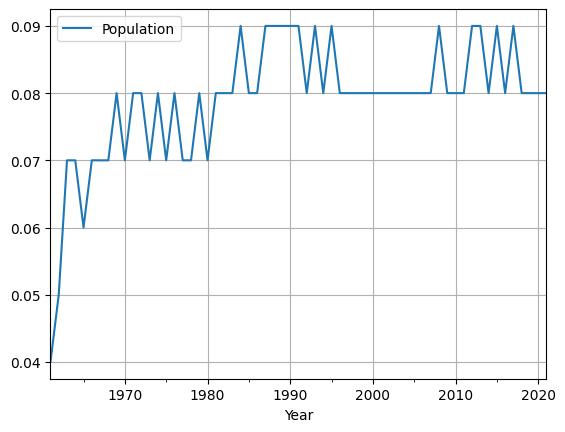

In [52]:
diff_df.plot(grid=True)

In [53]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                -3.410789
p-value                        0.010597
Lags Used                      2.000000
Number of Observation Used    58.000000
Critical Value (1%)           -3.548494
Critical Value (5%)           -2.912837
Critical Value (10%)          -2.594129
dtype: float64


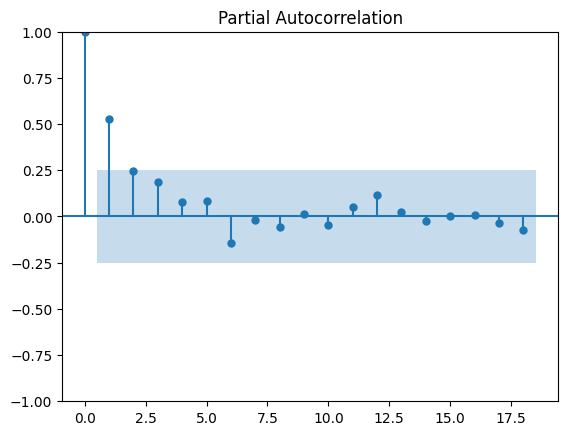

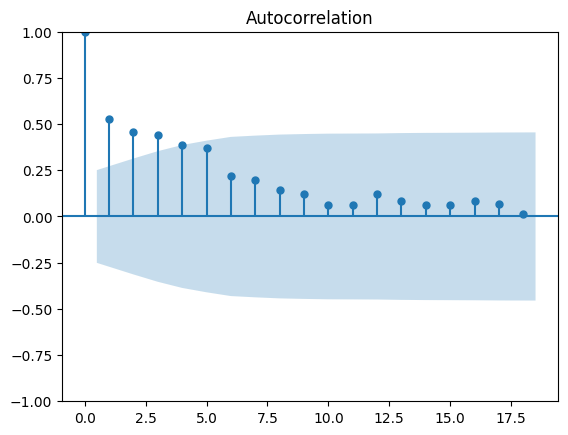

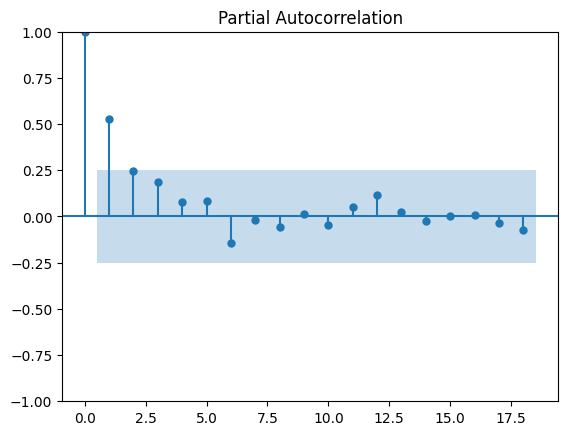

In [54]:
plot_acf(diff_df)
plot_pacf(diff_df)

In [63]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(30)

In [64]:
df.shape

(62, 1)

<Axes: xlabel='Year'>

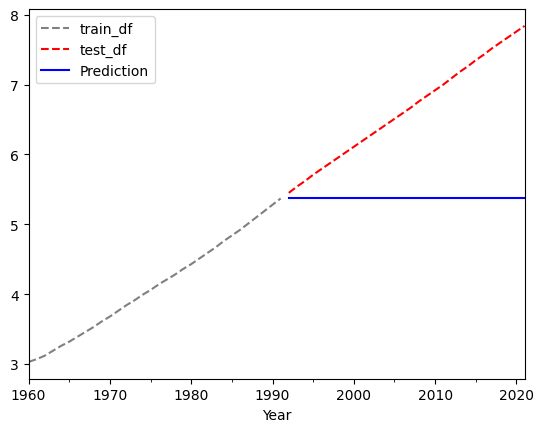

In [65]:
train_df['Population'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Population'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [77]:
rmse_single_exp_train = mean_squared_error(train_df, single_exp_train_pred)**0.5
rmse_single_exp_test = mean_squared_error(test_df, single_exp_test_pred)**0.5
mape_single_exp_train = mean_absolute_percentage_error(train_df, single_exp_train_pred)
mape_single_exp_test = mean_absolute_percentage_error(test_df, single_exp_test_pred)

print('Train RMSE :',rmse_single_exp_train)
print('Test RMSE :',rmse_single_exp_test)
print('Train MAPE :',mape_single_exp_train)
print('Test MAPE :',mape_single_exp_test)

Train RMSE : 0.07512489708946067
Test RMSE : 1.4591241676942968
Train MAPE : 0.017717130533787564
Test MAPE : 0.1822560482466195


In [68]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=15, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(30)

<Axes: xlabel='Year'>

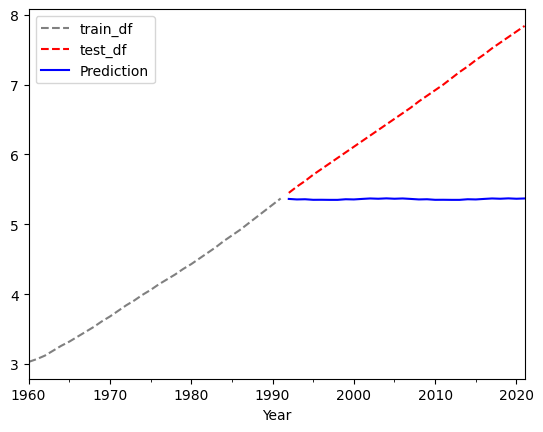

In [69]:
train_df['Population'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Population'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [78]:
rmse_double_exp_train = mean_squared_error(train_df, double_exp_train_pred)**0.5
rmse_double_exp_test = mean_squared_error(test_df, double_exp_test_pred)**0.5
mape_double_exp_train = mean_absolute_percentage_error(train_df, double_exp_train_pred)
mape_double_exp_test =  mean_absolute_percentage_error(test_df, double_exp_test_pred)

print('Train RMSE :',rmse_double_exp_train)
print('Test RMSE :',rmse_double_exp_test)
print('Train MAPE :',mape_double_exp_train)
print('Test MAPE :',mape_double_exp_test)

Train RMSE : 0.09996450398988417
Test RMSE : 1.4666090251876638
Train MAPE : 0.021586382901437544
Test MAPE : 0.18380456969578862


In [74]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

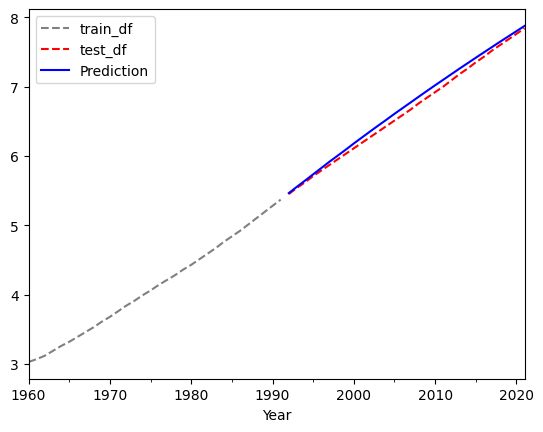

In [75]:
train_df['Population'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Population'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

In [84]:
rmse_ar_train = mean_squared_error(train_df, ar_train_pred)**0.5
rmse_ar_test = mean_squared_error(test_df, ar_test_pred)**0.5
mape_ar_train = mean_absolute_percentage_error(train_df, ar_train_pred)
mape_ar_test =  mean_absolute_percentage_error(test_df, ar_test_pred)

print('Train RMSE :',rmse_ar_train)
print('Test RMSE :', rmse_ar_test)
print('Train MAPE :',mape_ar_train)
print('Test MAPE :',mape_ar_test )

Train RMSE : 0.5357198887595561
Test RMSE : 0.07101317156512676
Train MAPE : 0.03292181700920583
Test MAPE : 0.009806242578762331


In [85]:
comparision_df = pd.DataFrame(data=[
    ['Single Exp Smoothing', rmse_single_exp_test, mape_single_exp_test],
    ['Double Exp Smoothing', rmse_double_exp_test, mape_double_exp_test],
    ['ARIMA', rmse_ar_test, mape_ar_test]
    ],
    columns=['Model', 'RMSE', 'MAPE'])
comparision_df.set_index('Model', inplace=True)

In [86]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
ARIMA,0.071013,0.009806
Single Exp Smoothing,1.459124,0.182256
Double Exp Smoothing,1.466609,0.183805


In [87]:
ar = ARIMA(df, order=(15,1,15)).fit()
ar_test_pred = ar.forecast(30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


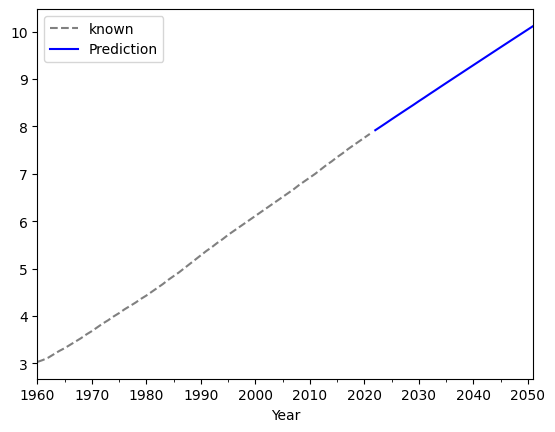

In [88]:
df['Population'].plot(style='--', color='gray', legend=True, label='known')
ar_test_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [89]:
import pickle

In [90]:
pickle.dump(ar, open('prediksi_populasi.sav','wb'))